#### Load Data

In [181]:
import pandas as pd
from pathlib import Path
from matplotlib import pyplot as plt

def load_wine_data_df(csv_path):
    """
    Helper function for loading wine data.
    """
    csv_path = Path(csv_path)
    if not csv_path:
        return ValueError("File does not exist")
    
    wine_data_df = pd.read_csv(csv_path, sep=';')

    return wine_data_df

red_wine_df = load_wine_data_df('data/winequality-red.csv')
red_wine_df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


#### Exploratory Data Analysis

In [182]:
red_wine_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


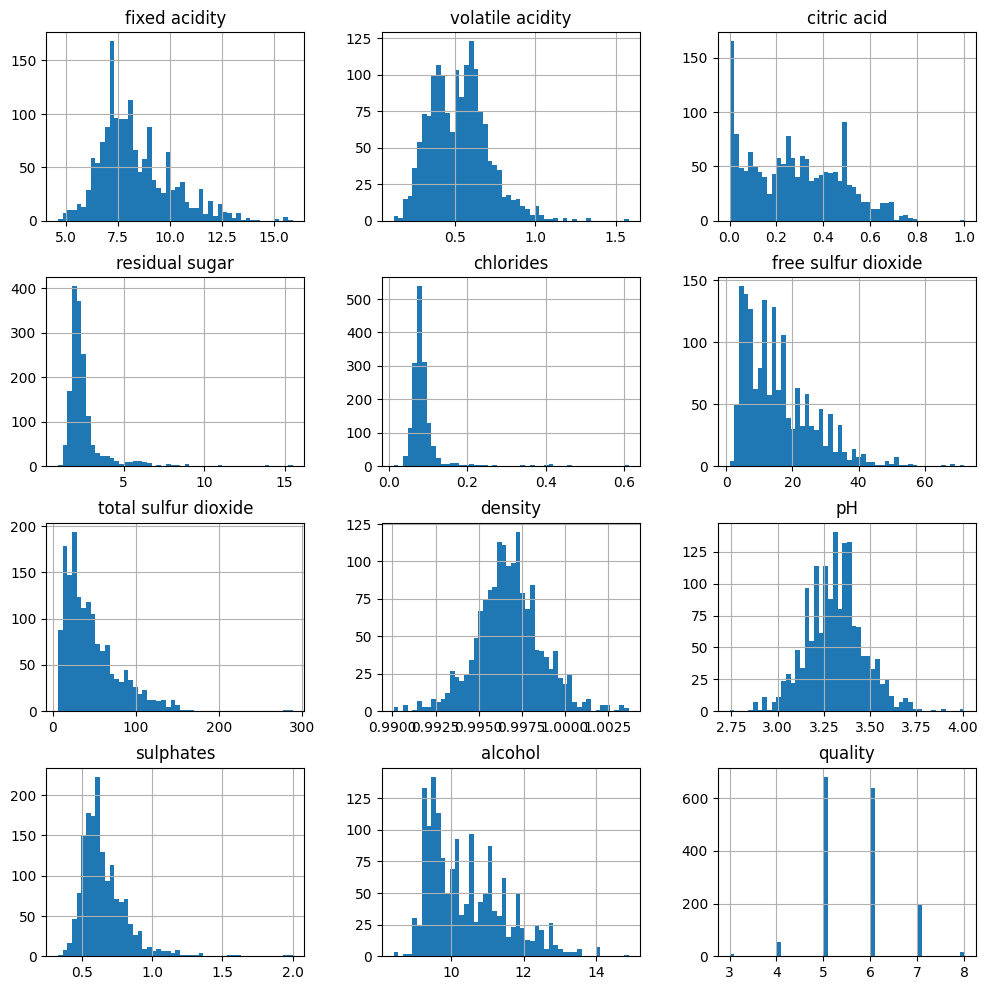

In [183]:
red_wine_df.hist(bins=50, figsize=(12, 12))
plt.show()

In [184]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, PowerTransformer

# Define pipeline
preprocessing = Pipeline([
    ('impute_', SimpleImputer(strategy='mean')),  # Impute missing values
    ('scaled_', StandardScaler()),  # Scale the features
    ('yeo_johnson_', PowerTransformer(method='yeo-johnson'))  # Apply Yeo-Johnson transformation
])

# Fit and transform data
transformed_red_wine_data = preprocessing.fit_transform(red_wine_df)

# Create dataframe
transformed_red_wine_df = pd.DataFrame(
        transformed_red_wine_data, columns=preprocessing.get_feature_names_out(),
        index=red_wine_df.index
)

#### Now lets see how our feature distributions look after applying transformations

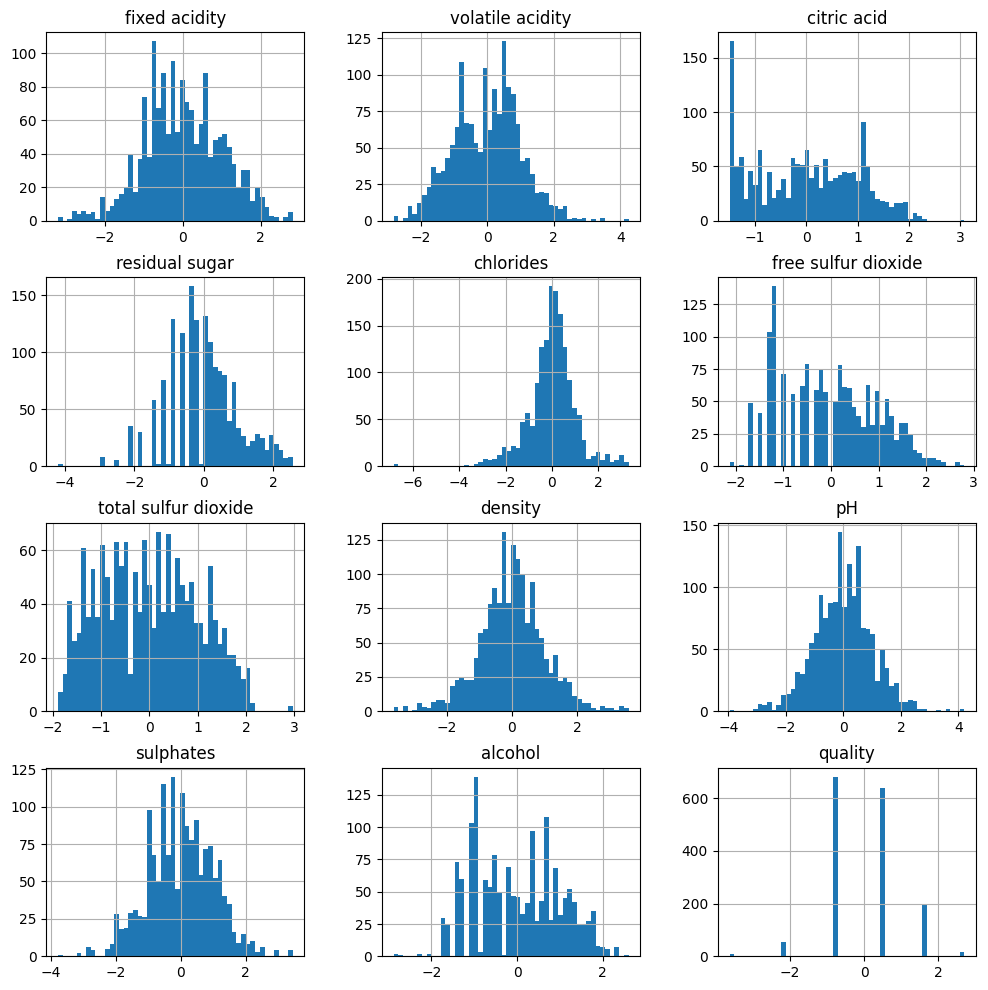

In [185]:
transformed_red_wine_df.hist(bins=50, figsize=(12, 12))
plt.show()

In [186]:
# Correlations

transformed_red_wine_df.corr()['quality']

fixed acidity           0.103838
volatile acidity       -0.395955
citric acid             0.221533
residual sugar          0.030221
chlorides              -0.193809
free sulfur dioxide    -0.045021
total sulfur dioxide   -0.170092
density                -0.173192
pH                     -0.058498
sulphates               0.342194
alcohol                 0.458828
quality                 1.000000
Name: quality, dtype: float64

In [187]:
from sklearn.model_selection import train_test_split

red_wine_df_train, red_wine_df_test = train_test_split(red_wine_df, test_size=0.2, random_state=914)

# train features and labels
train_features = red_wine_df_train.drop("quality", axis=1)
train_labels   = red_wine_df_train["quality"].copy()

# test features and labels
test_features = red_wine_df_test.drop("quality", axis=1)
test_labels   = red_wine_df_test["quality"].copy()

train_features.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
1460,6.4,0.42,0.09,2.3,0.054,34.0,64.0,0.99724,3.41,0.68,10.4
1114,5.0,0.40,0.50,4.3,0.046,29.0,80.0,0.99020,3.49,0.66,13.6
516,12.5,0.60,0.49,4.3,0.100,5.0,14.0,1.00100,3.25,0.74,11.9
1538,6.2,0.64,0.09,2.5,0.081,15.0,26.0,0.99538,3.57,0.63,12.0
125,9.0,0.62,0.04,1.9,0.146,27.0,90.0,0.99840,3.16,0.70,9.4


#### First lets test a random forest regressor to see if our errors are reasonable with our training data

In [188]:
# Random forrest regressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import make_pipeline

forest_reg = make_pipeline(preprocessing, RandomForestRegressor(random_state=42))
forest_reg.fit(train_features, train_labels)
predictions = forest_reg.predict(test_features)
forest_rmses = mean_squared_error(test_labels, predictions, squared=False)
pd.Series(forest_rmses).describe()

/home/vdomingu3z/.virtualenvs/machine_learning/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


count    1.00000
mean     0.63809
std          NaN
min      0.63809
25%      0.63809
50%      0.63809
75%      0.63809
max      0.63809
dtype: float64

#### Feature selection TODO(perhaps scrap this as feature selector is better)

In [189]:
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import FeatureUnion

# Define a new pipeline that retains our original features
union_preprocessor = FeatureUnion(
    transformer_list=[
        ('preprocessed', preprocessing),  # Apply numerical transformer to selected features
        ('original_columns', 'passthrough')  # Retain all original columns
    ]
)

# Fit and transform preprocessing pipeline on training data
X_train_preprocessed = union_preprocessor.fit_transform(train_features)

# Perform feature selection
selector = SelectKBest(score_func=f_regression, k=5)  # Select top 5 features
X_train_selected = selector.fit_transform(X_train_preprocessed, train_labels)

# Get the indices of the selected features
selected_indices = selector.get_support(indices=True)

# Create dataframe
X_train_preprocessed_df = pd.DataFrame(
        X_train_preprocessed, columns=union_preprocessor.get_feature_names_out(),
        index=train_features.index
)

# Get the feature names
feature_names = X_train_preprocessed_df.columns[selected_indices]

# Print out the best features
pd.Series(feature_names)

0        preprocessed__volatile acidity
1               preprocessed__sulphates
2                 preprocessed__alcohol
3    original_columns__volatile acidity
4             original_columns__alcohol
dtype: object

#### Now, lets find the best model with the best parameters

In [192]:
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR

# Define a new pipeline that retains our original features, and performs feature selection
union_preprocessor_w_feat_selection = FeatureUnion(
    transformer_list=[
        ('preprocessed', preprocessing),  # Apply numerical transformer to selected features
        ('original_columns', 'passthrough'),  # Retain all original columns
        ('feature_selection', SelectKBest(score_func=f_regression, k=7)),  # Feature selection
    ]
)


# Define models and their hyperparameters
models = [
    {
        'name': 'Linear Regression',
        'estimator': Pipeline([
            ('preprocessing', union_preprocessor_w_feat_selection),
            ('regressor', LinearRegression())
        ]),
        'hyperparameters': {
            'regressor__fit_intercept': [True, False],
        }
    },
    {
        'name': 'Decision Tree Regression',
        'estimator': Pipeline([
            ('preprocessing', union_preprocessor_w_feat_selection),
            ('regressor', DecisionTreeRegressor())
        ]),
        'hyperparameters': {
            'regressor__max_depth': [3, 5, 7, 10],
            'regressor__min_samples_split': [2, 5, 10]
        }
    },
    {
        'name': 'Random Forest Regression',
        'estimator': Pipeline([
            ('preprocessing', union_preprocessor_w_feat_selection),
            ('regressor', RandomForestRegressor())
        ]),
        'hyperparameters': {
            'regressor__n_estimators': [100, 200, 300],
            'regressor__max_depth': [3, 5, 7, 10],
            'regressor__min_samples_split': [2, 5, 10]
        }
    },
    {
        'name': 'Support Vector Regression',
        'estimator': Pipeline([
            ('preprocessing', union_preprocessor_w_feat_selection),
            ('regressor', SVR())
        ]),
        'hyperparameters': {
            'regressor__C': [0.1, 1, 10],
            'regressor__epsilon': [0.1, 0.2, 0.5]
        }
    }
]

# Define evaluation metric.
scoring = 'neg_mean_squared_error'

# Set up cross-validation.
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Perform grid search for each model.
for model in models:
    
    # Using n_jobs=-1, for fastest analysis
    grid_search = GridSearchCV(model['estimator'], model['hyperparameters'], scoring=scoring, cv=cv, n_jobs=-1)
    grid_search.fit(train_features, train_labels)
    
    # Print best parameters and performance
    print(f"Best parameters for {model['name']}: {grid_search.best_params_}")
    print(f"Best {scoring} for {model['name']}: {-grid_search.best_score_}")

# Select best model based on evaluation metric.
best_model = grid_search.best_estimator_

# Evaluate best model on test data.
y_pred = best_model.predict(test_features)
mse = mean_squared_error(test_labels, y_pred)
print(f"Mean Squared Error on test data: {mse}")

Best parameters for Linear Regression: {'regressor__fit_intercept': False}
Best neg_mean_squared_error for Linear Regression: 0.40273296060086816
Best parameters for Decision Tree Regression: {'regressor__max_depth': 5, 'regressor__min_samples_split': 5}
Best neg_mean_squared_error for Decision Tree Regression: 0.4401935126743931
Best parameters for Random Forest Regression: {'regressor__max_depth': 10, 'regressor__min_samples_split': 2, 'regressor__n_estimators': 300}
Best neg_mean_squared_error for Random Forest Regression: 0.34143580163908
Best parameters for Support Vector Regression: {'regressor__C': 10, 'regressor__epsilon': 0.2}
Best neg_mean_squared_error for Support Vector Regression: 0.3993029296507101
Mean Squared Error on test data: 0.44355609478400426
